# Full Scale Sentiment Analysis (Stateless & Robust)
## **Course:** Advanced NLP (Fall 2025)

## This notebook implements a production-grade pipeline designed for large datasets (950k+ posts).
## Key Features:
### 1. **Stateless Inference:** Each post is processed independently. The LLM retains zero memory of previous posts.
### 2. **Robust Checkpointing:** Results are saved incrementally. If the system crashes, execution resumes automatically from the last saved row.
### 3. **Memory Efficient:** Processes data in batches to respect RAM limits.

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ollama
from tqdm import tqdm

## Add scripts path for modular imports

In [3]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.preprocessor import TextPreprocessor

## Visualization Style

In [4]:
sns.set_theme(style="whitegrid")

## 1. Configuration

### Paths

In [5]:
DATA_DIR = "../data"
PROCESSED_DIR = "../data/processed"
RESULTS_DIR = "../results"

### Create directories if they don't exist

In [6]:
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

### Files

In [7]:
MASTER_DATA_FILE = os.path.join(PROCESSED_DIR, "master_cleaned_dataset.csv")
FINAL_RESULTS_FILE = os.path.join(PROCESSED_DIR, "final_sentiment_results.csv")

In [8]:
MODEL_NAME = "gemma3:27b"
BATCH_SIZE = 100  # Save to disk every 100 posts
SOURCES = ["kafiha", "TweetyChannel", "radiofarda", "iranintlTV", "bbcpersian"]

## 2. Data Preparation (Load, Clean, Filter)
### To ensure indices align perfectly for resuming, we first create a **Master Cleaned Dataset**.
### If this file already exists, we skip this step to save time.

In [ ]:
if os.path.exists(MASTER_DATA_FILE):
    print(f"✅ Master dataset found at {MASTER_DATA_FILE}. Loading...")
    full_df = pd.read_csv(MASTER_DATA_FILE)
else:
    print("⚠️ Master dataset not found. Building from scratch...")
    
    # 1. Load Raw Data
    all_dfs = []
    for source in SOURCES:
        path = os.path.join(DATA_DIR, f"{source}_messages.csv")
        if os.path.exists(path):
            print(f"   - Loading {source}...")
            temp_df = pd.read_csv(path)
            temp_df['source'] = source
            all_dfs.append(temp_df)
    
    if not all_dfs:
        raise FileNotFoundError("No source CSV files found in data/ directory!")
        
    full_df = pd.concat(all_dfs, ignore_index=True)
    
    # 2. Preprocessing
    print("   - Initializing Preprocessor...")
    preprocessor = TextPreprocessor()
    
    # Fill NaNs
    full_df['text'] = full_df['text'].fillna('')
    full_df['emoji_reactions'] = full_df['emoji_reactions'].fillna('')
    
    print("   - Cleaning text (This might take a few minutes for 900k+ rows)...")
    tqdm.pandas(desc="Cleaning")
    full_df['clean_post_text'] = full_df['text'].progress_apply(preprocessor.clean_text)
    full_df['clean_reactions'] = full_df['emoji_reactions'].apply(preprocessor.clean_reactions)
    
    # 3. Filtering (Remove short/empty texts)
    initial_len = len(full_df)
    full_df = full_df[full_df['clean_post_text'].str.len() > 10].reset_index(drop=True)
    print(f"   - Filtered {initial_len - len(full_df)} short/empty posts.")
    
    # 4. Save Master File
    print(f"   - Saving Master Dataset ({len(full_df)} rows)...")
    full_df.to_csv(MASTER_DATA_FILE, index=False, encoding='utf-8-sig')

print(f"🚀 Ready to process {len(full_df)} posts.")

## 3. Stateless Inference Engine
### We define the logic to query Llama 3.
### **Important:** `messages` list is recreated inside the function every time to ensure **Zero Memory** of previous posts.

In [ ]:
def get_sentiment_label(text, reactions):
    """
    Stateless Sentiment Analysis using Few-Shot Prompting.
    Each call is independent. No context is shared between posts.
    """
    prompt_text = f"متن پست: {text}\nواکنش‌های کاربران: {reactions}"
    
    # Optimized Few-Shot Prompt
    system_prompt = (
        "تو یک تحلیلگر دقیق احساسات فارسی هستی. بر اساس مثال‌های زیر، پست جدید را طبقه‌بندی کن.\n"
        "دسته‌بندی‌ها: ['خوشحال', 'ناراحت', 'عصبانی', 'مضطرب', 'خنثی', 'نگران']\n\n"
        "--- مثال‌های آموزشی ---\n"
        "مثال ۱ (تبلیغات/خبر): تور استانبول ویژه بلک فرایدی. -> خنثی\n"
        "مثال ۲ (غم/دلتنگی): فراموش کردنت سخته عزیزم. -> ناراحت\n"
        "مثال ۳ (طنز/موفقیت): وای چقدر خوشحالم تموم شد. -> خوشحال\n"
        "مثال ۴ (خشم/اعتراض): چرا وضعیت اینترنت اینطوریه؟ -> عصبانی\n"
        "مثال ۵ (نگرانی/پول): آخر ماه شد و حقوق نریختن. -> نگران\n"
        "--- پایان مثال‌ها ---\n"
        "فقط برچسب را بنویس."
    )

    try:
        # Generate a fresh request (Stateless)
        response = ollama.chat(model=MODEL_NAME, messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': prompt_text},
        ])
        
        label = response['message']['content'].strip()
        
        # Basic Validation
        valid_labels = ['خوشحال', 'ناراحت', 'عصبانی', 'مضطرب', 'خنثی', 'نگران']
        for v in valid_labels:
            if v in label: return v
        return "خنثی" # Fallback
    except Exception as e:
        return "Error"

## 4. Main Execution Loop (With Resume Capability)
### We check `final_sentiment_results.csv`. If it exists, we count the rows and skip that many in `full_df`.

#### 4.1 Check Progress

In [ ]:
if os.path.exists(FINAL_RESULTS_FILE):
    # Count lines in existing file to determine start index
    # We substract 1 for the header
    with open(FINAL_RESULTS_FILE, 'r', encoding='utf-8-sig') as f:
        processed_count = sum(1 for _ in f) - 1
    
    # Determine mode
    write_mode = 'a' # Append
    header = False   # Don't write header again
    start_index = processed_count
    print(f"🔄 Resuming from index {start_index}...")
else:
    write_mode = 'w' # Write new
    header = True    # Write header
    start_index = 0
    print("🟢 Starting new analysis...")

#### 4.2 Inference Loop

In [ ]:
if start_index < len(full_df):
    batch_buffer = []
    
    # Iterate from the last checkpoint
    for i in tqdm(range(start_index, len(full_df)), desc="Processing", initial=start_index, total=len(full_df)):
        
        row = full_df.iloc[i]
        
        # Call LLM (Stateless)
        sentiment = get_sentiment_label(row['clean_post_text'], row['clean_reactions'])
        
        # Prepare Result Row
        result_dict = {
            'msg_id': row.get('msg_id'),
            'date': row.get('date'),
            'source': row.get('source'),
            'clean_text': row['clean_post_text'], # Saving cleaned text to save space
            'sentiment': sentiment
        }
        batch_buffer.append(result_dict)
        
        # 3. Save to Disk (Batch)
        if len(batch_buffer) >= BATCH_SIZE:
            df_batch = pd.DataFrame(batch_buffer)
            df_batch.to_csv(FINAL_RESULTS_FILE, mode=write_mode, header=header, index=False, encoding='utf-8-sig')
            
            # Reset buffer and flags
            batch_buffer = []
            header = False # Never write header after first batch
            write_mode = 'a' # Always append hereafter
            
    # 4. Save remaining items
    if batch_buffer:
        df_batch = pd.DataFrame(batch_buffer)
        df_batch.to_csv(FINAL_RESULTS_FILE, mode=write_mode, header=header, index=False, encoding='utf-8-sig')

    print("\n✅ Analysis Complete! All rows processed.")
else:
    print("\n✅ All rows were already processed!")

### 5. Visualization & Statistics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

##### 5.1 CONFIGURATION & ROBUST DATA LOADING

In [2]:
PROCESSED_DIR = "../data/processed"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

### Set Style (English Friendly)

In [3]:
sns.set_theme(style="whitegrid")

Loading final results...
✅ Data Loaded Successfully: 291759 valid rows.
Generating Trend Chart (English)...


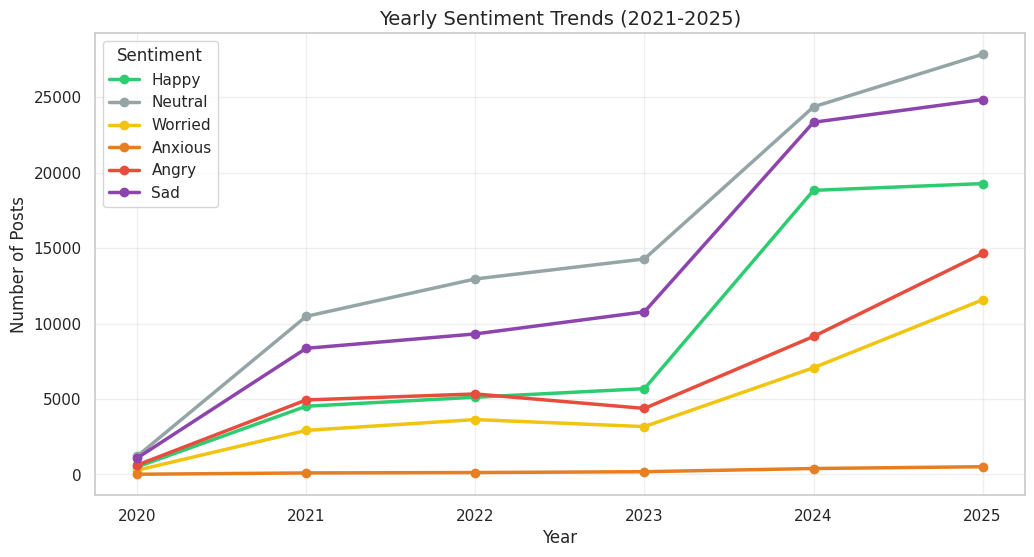

Generating Statistics Table...
Saved: table_sentiments_yearly.csv


sentiment_eng,Happy,Neutral,Worried,Anxious,Angry,Sad
year,,,,,,
2020,13.5,32.7,7.4,0.4,16.7,29.3
2021,14.4,33.5,9.3,0.3,15.8,26.7
2022,14.0,35.5,10.0,0.4,14.6,25.5
2023,14.8,37.1,8.2,0.5,11.4,28.0
2024,22.6,29.3,8.5,0.5,11.0,28.1
2025,19.5,28.2,11.7,0.5,14.8,25.2


Generating Platform Comparison (Hope/Despair)...


/tmp/ipykernel_11247/998867561.py:132: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(RESULTS_DIR, "final_mood_barchart.png"))
/tmp/ipykernel_11247/998867561.py:132: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(RESULTS_DIR, "final_mood_barchart.png"))
/home/mdvr0480/Public/ANLP/ai-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mdvr0480/Public/ANLP/ai-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


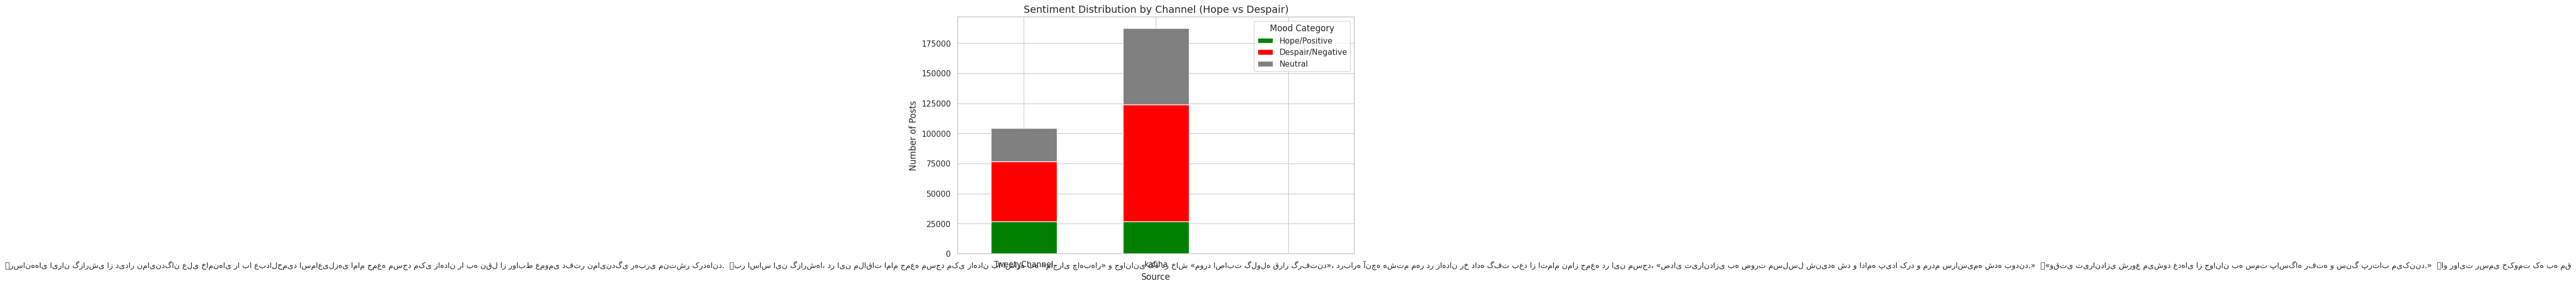


✅ All outputs generated successfully in 'results' folder!


In [ ]:
print("Loading final results...")
file_path = os.path.join(PROCESSED_DIR, "final_sentiment_results.csv")

try:
    # LOAD DATA ROBUSTLY
    df = pd.read_csv(
        file_path, 
        engine='python',
        on_bad_lines='skip',
        encoding='utf-8',
        encoding_errors='replace'
    )
    
    # Parse Dates
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']) 
    df['year'] = df['date'].dt.year.astype(int)
    
    print(f"✅ Data Loaded Successfully: {len(df)} valid rows.")

    # ==========================================
    # 5.2 PRE-PROCESSING (Translate to English)
    # ==========================================
    sentiment_map = {
        'خوشحال': 'Happy',
        'خنثی': 'Neutral',
        'نگران': 'Worried',
        'مضطرب': 'Anxious',
        'عصبانی': 'Angry',
        'ناراحت': 'Sad'
    }
    
    df['sentiment_eng'] = df['sentiment'].map(sentiment_map).fillna('Neutral')
    eng_labels = ['Happy', 'Neutral', 'Worried', 'Anxious', 'Angry', 'Sad']
    colors = ['#2ecc71', '#95a5a6', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']

    # ==========================================
    # 5.3 REQUIREMENT 1: 5-YEAR TREND CHART
    # ==========================================
    print("Generating Trend Chart (English)...")
    
    yearly_counts = df.groupby(['year', 'sentiment_eng']).size().unstack(fill_value=0)
    
    for label in eng_labels:
        if label not in yearly_counts.columns:
            yearly_counts[label] = 0
    
    yearly_counts = yearly_counts[eng_labels]

    plt.figure(figsize=(12, 6))
    for i, label in enumerate(eng_labels):
        plt.plot(yearly_counts.index, yearly_counts[label], marker='o', linewidth=2.5, label=label, color=colors[i])
    
    plt.title('Yearly Sentiment Trends (2021-2025)', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.legend(title='Sentiment')
    plt.grid(True, alpha=0.3)
    plt.xticks(yearly_counts.index)
    
    plt.savefig(os.path.join(RESULTS_DIR, "chart_6labels_trend.png"))
    plt.show()

    # ==========================================
    # 5.4 REQUIREMENT 2: YEARLY STATISTICS TABLE
    # ==========================================
    print("Generating Statistics Table...")
    
    yearly_pct = yearly_counts.div(yearly_counts.sum(axis=1), axis=0) * 100
    yearly_pct = yearly_pct.round(1)
    
    yearly_pct.to_csv(os.path.join(RESULTS_DIR, "table_sentiments_yearly.csv"))
    print("Saved: table_sentiments_yearly.csv")
    display(yearly_pct)

    # ==========================================
    # 5.5 REQUIREMENT 3: HOPE VS DESPAIR (BY PLATFORM)
    # ==========================================
    print("Generating Platform Comparison (Hope/Despair)...")
    
    def get_mood_category(sent):
        if sent == 'Happy': return 'Hope/Positive'
        if sent in ['Sad', 'Angry', 'Anxious', 'Worried']: return 'Despair/Negative'
        return 'Neutral'
    
    df['mood_category'] = df['sentiment_eng'].apply(get_mood_category)
    
    # Group by Source (Calculation only, no saving to CSV)
    mood_stats = df.groupby(['source', 'mood_category']).size().unstack(fill_value=0)
    
    # Prepare Plot Data
    plot_data = mood_stats[['Hope/Positive', 'Despair/Negative', 'Neutral']]
    
    # Plot Stacked Bar
    plot_data.plot(
        kind='bar', 
        stacked=True, 
        color=['#008000', '#FF0000', '#808080'], 
        figsize=(10, 6)
    )
    plt.title("Sentiment Distribution by Channel (Hope vs Despair)", fontsize=14)
    plt.ylabel("Number of Posts", fontsize=12)
    plt.xlabel("Source", fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title="Mood Category")
    
    plt.savefig(os.path.join(RESULTS_DIR, "final_mood_barchart.png"))
    plt.show()

    print("\n✅ All 3 required outputs generated successfully in 'results' folder!")

except FileNotFoundError:
    print("❌ Error: Input file not found. Please run the inference loop first.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")